In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split

In [2]:
Df = pd.read_csv('Faellesdata_cleaned.csv')

In [3]:
x_train, x_test, y_train, y_test = train_test_split(Df.drop('IsMigratorInt', axis=1), Df['IsMigratorInt'], test_size=0.2, random_state=42)

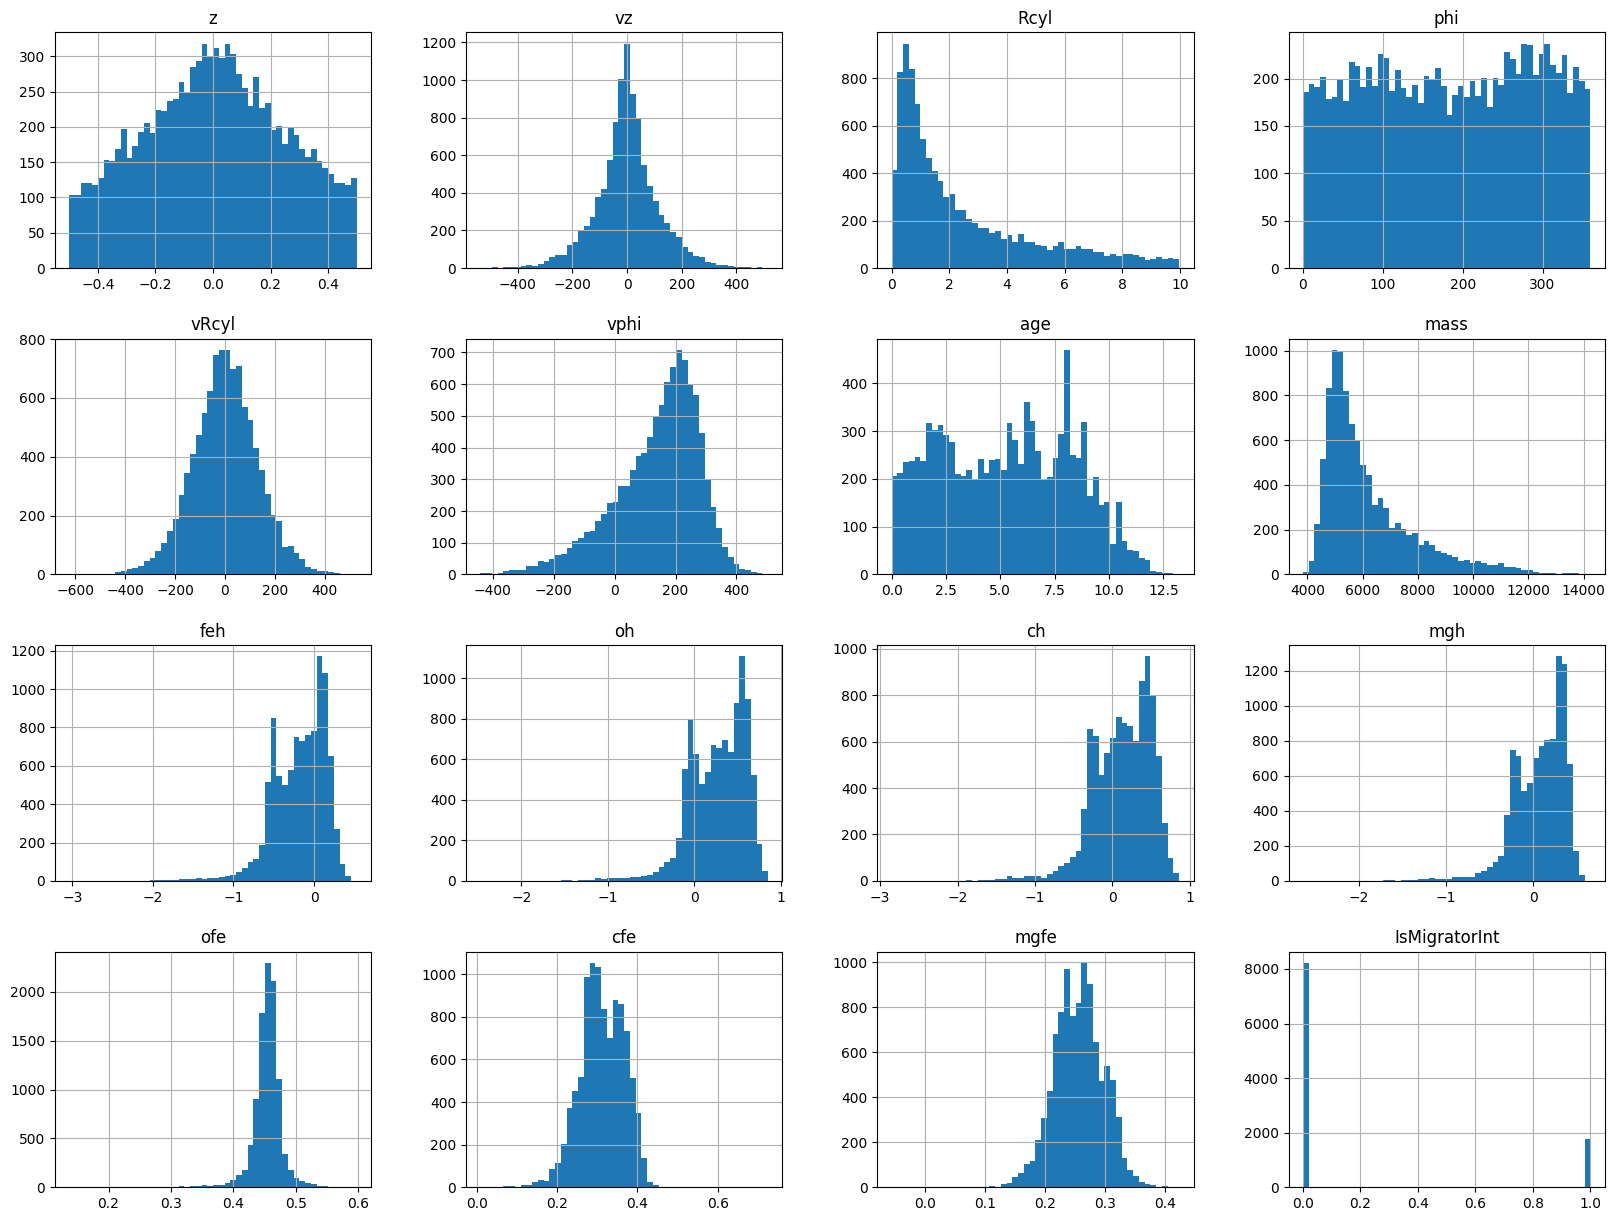

In [4]:
Df.hist(bins = 50, figsize = (20, 15));
#plt.savefig("Histograms")

In [5]:
import statsmodels.api as sm
import time
import itertools
from ISLP.models import (ModelSpec as MS,
                         summarize, poly)

In [79]:
#Make dataframe thats called DataFinal that has x_train and y_train
DataFinal = x_train
DataFinal['IsMigratorInt'] = y_train


In [ ]:
DataFinalTest = x_test
DataFinalTest['IsMigratorInt'] = y_test

In [43]:
# Found on google
def processSubset(feature_set):
    # Fit model on feature_set and calculate RSS
    X = MS(list(feature_set)).fit_transform(DataFinal[list(feature_set)])
    model = sm.GLM(
        DataFinal["IsMigratorInt"]
        , X
        , family = sm.families.Binomial()
        )
    regr = model.fit()
    TErate = np.mean((regr.predict(X) >= 0.5) != DataFinal['IsMigratorInt'])
    MSEtest: float = ((regr.predict((sm.add_constant(DataFinalTest[list(feature_set)])) ) - y_test)**2).mean()

    return {"model": regr, "TErate": TErate, "MSEtest": MSEtest}

def getBest(k):
    
    tic = time.time()
    
    results = []
    
    for combo in itertools.combinations(DataFinal.iloc[:,:-2], k):
        results.append(processSubset(combo))
    
    # Wrap everything up in a nice dataframe
    models = pd.DataFrame(results)
    
    # Choose the model with the highest RSS
    best_model = models.loc[models['TErate'].argmin()]
    
    toc = time.time()
    print("Processed", models.shape[0], "models on", k, "predictors in", (toc-tic), "seconds.")
    
    # Return the best model, along with some other useful information about the model
    return best_model

In [ ]:
models_best = pd.DataFrame(columns=["TErate", "model", "MSEtest"])

tic = time.time()
for i in range(len(DataFinal.iloc[:,:-1].columns) + 1):
    models_best.loc[i] = getBest(i)
 
toc = time.time()
print("Total elapsed time:", (toc-tic), "seconds.")

Processed 1 models on 0 predictors in 0.037322998046875 seconds.
Processed 14 models on 1 predictors in 0.7624650001525879 seconds.
Total elapsed time: 0.8046815395355225 seconds.


In [40]:
# i = 15
# models_best.loc[i] = getBest(i)

In [71]:
Outcome = models_best.apply(lambda row: row[1].params, axis=1) # get the parameters of the best model for each number of predictors
Outcome = pd.DataFrame(Outcome)
Outcome.to_csv('OutcomeBestSubsetSelection.csv')
Outcome

C:\Users\chril\AppData\Local\Temp\ipykernel_6912\2678531596.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Outcome = models_best.apply(lambda row: row[1].params, axis=1) # get the parameters of the best model for each number of predictors


,Rcyl,intercept
0,NaN,-1.531514
1,0.480334,-3.091869


In [73]:
TEMSE = models_best[['TErate', 'MSEtest']]
TEMSE.to_csv('TEreteAndMSETest.csv')
TEMSE

,TErate,MSEtest
0,0.177772,0.145027
1,0.16127,0.11626


In [74]:
# rsquare = models_best.apply(lambda row: row[1].rsquared, axis=1) # get the R^2 of the best model for each number of predictors
bic = models_best.apply(lambda row: row[1].bic, axis=1) # get the BIC of the best model for each number of predictors
aic = models_best.apply(lambda row: row[1].aic, axis=1) # get the Mallow's Cp of the best model for each number of predictors
# print(rsquare)
# print(dir(models_best.loc[2, "model"]))


C:\Users\chril\AppData\Local\Temp\ipykernel_6912\357770356.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  bic = models_best.apply(lambda row: row[1].bic, axis=1) # get the BIC of the best model for each number of predictors
c:\Users\chril\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\genmod\generalized_linear_model.py:1923: FutureWarning: The bic value is computed using the deviance formula. After 0.13 this will change to the log-likelihood based formula. This change has no impact on the relative rank of models compared using BIC. You can directly access the log-likelihood version using the `bic_llf` attribute. You can suppress this message by calling statsmodels.genmod.generalized_linear_model.SET_USE_BIC_LLF with True to get the LLF-based version now or False to retainth

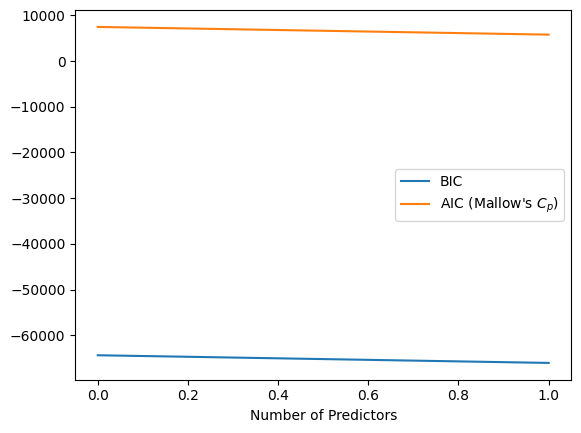

In [ ]:
# plt.plot(rsquare, label="$R^2$")
# plt.legend()
# plt.xlabel('Number of Predictors')
# plt.show()

plt.plot(bic, label="BIC")
plt.plot(aic, label="AIC (Mallow's $C_p$)")
plt.legend()
plt.xlabel('Number of Predictors');
plt.savefig("BICandAIC")

In [80]:
print(bic.idxmin()) #Finds where minimum  and maximum values are
print(aic.idxmin())
# print(rsquare.idxmax())

# print(rsquare.max()) #To compare k=4 and k=3
# print(rsquare[3])


1
1
